In [49]:
%matplotlib inline

import pandas as pd
import numpy as np
# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix,roc_curve,auc


import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

 _______________________________________________
# Binary Classification - Rock & Jazz
## # echonest audio features
 _______________________________________________

#### Useful functions for plotting graphs

In [50]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

In [51]:
from sklearn.metrics import roc_curve,auc

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

# 1. Preprocessing

In [52]:
# read dataset
echo_genres = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Datasets/echo_features.csv')
echo_genres.set_index('track_id', inplace=True)
echo_genres.head()
echo_genres.drop('listens', axis=1, inplace=True)
echo_genres.drop('comments', axis=1, inplace=True)

In [53]:
# select subset of data with genres: Hip Hop or Rock
dataset = echo_genres[echo_genres['genre_top'].isin(['Rock','Jazz'])]
dataset.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,duration,bit_rate
track_id,,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,128.537,0.788251,Jazz,82,256
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,120.790,0.650452,Jazz,326,256
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,135.468,0.682397,Jazz,354,256
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,120.218,0.917613,Jazz,232,256
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock,405,256


In [54]:
# check shape
dataset.shape

(4133, 11)

In [55]:
# remove duplicates
dataset.drop_duplicates(keep=False, inplace=True)
print(f"shape after removing duplicates{dataset.shape}")

shape after removing duplicates(4133, 11)


In [56]:
#display counts and percentage of labels
pd.concat([dataset.genre_top.value_counts(),
                round(dataset.genre_top.value_counts(normalize=True).mul(100),2)],axis=1, keys=('counts','percentage (%)'))

,counts,percentage (%)
Rock,3892,94.17
Jazz,241,5.83


In [57]:
# encoding labels
le = preprocessing.LabelEncoder()
dataset['genre_top'] = le.fit_transform(dataset['genre_top'])
print('legend:\n0: Jazz\n1: Rock')
dataset.genre_top.value_counts()

legend:
0: Jazz
1: Rock


1    3892
0     241
Name: genre_top, dtype: int64

In [58]:
# Define the labels
labels = dataset[['genre_top']]
# labels has as index the id_track, this creates problems when plotting data after the features have been normalized.
# we reset the index from 0 to n
labels.reset_index(drop=True, inplace=True)
labels = labels['genre_top']

In [59]:
dataset.drop('genre_top', axis=1, inplace=True)

In [60]:
# normalize the dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset)
scaled_features

array([[ 1.02985274,  0.31691984,  0.07801309, ...,  1.40928694,
        -0.74576189,  0.19265136],
       [-0.75595289,  0.28577395, -0.51298494, ...,  0.88914674,
         0.36763498,  0.19265136],
       [ 0.03025499,  0.15425321, -0.55639444, ...,  1.00972906,
         0.49540183,  0.19265136],
       ...,
       [-1.32137482,  1.53890309,  1.2777149 , ..., -1.02483138,
        -0.07042281,  1.39291979],
       [-1.29503999,  1.73814459,  1.32968483, ..., -0.36176257,
        -0.13886933,  1.39291979],
       [-1.3662832 , -0.77481062,  0.93070439, ...,  0.68808105,
        -0.10692762,  1.39291979]])

# 2. PCA on normalized data (scaled_features)
## 2.1 Determine optimal number of components
### a) scree-plot
We use PCA to determine by how much we can reduce the dimensionality of our data.
We can use scree-plots and cumulative explained ratio plots to find the number of components to
use in further analysis.
- Screen-plots display the number of components against the variance explained by each component,sorted
in descending order of variance.
The cutoff is determined by the 'elbow' of the screen plot.

Text(0.5, 0, 'Principal Component #')

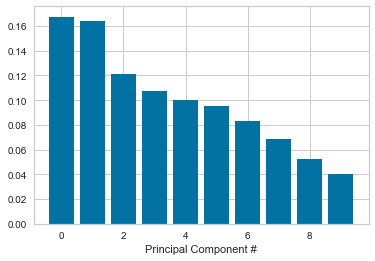

In [61]:
pca = PCA()
pca.fit(scaled_features)
# get explained variance ratios from PCA using all features
exp_variance = pca.explained_variance_ratio_
# plot explained variance
fig, ax= plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

From the plot we can see that is not straightforward to identify the optimal number of components.
We will determine the optimal number of components by inspecting the cumulative explained
variance plot.

### b) cumulative explained variance plot

Optimal number of components: 7
Explained variation per principal component:
[0.16755476 0.16441465 0.12149944 0.10725921 0.09997747 0.09562386
 0.0827644  0.06867635 0.05215482 0.04007505]


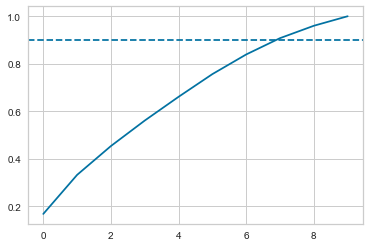

In [62]:
# calculate the cumulative explained variance
cum_exp_var = np.cumsum(exp_variance)
# plot the cumulative explained variance and draw a dashed line at 0.9\
# This line indicates how much variance (information) we want to retain
fig, ax= plt.subplots()
ax.plot(cum_exp_var)
ax.axhline(y=0.9, linestyle='--')

# find index where cum_exp_var exceeds 0.9 and adding 1 to that index to get the num of components
n_components = ((np.where(cum_exp_var > 0.9))[0][0])
print(f"Optimal number of components: {n_components}")
print(f"Explained variation per principal component:\n{pca.explained_variance_ratio_}")
# perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components,random_state=42)
pca.fit(scaled_features)
pca_proj = pca.transform(scaled_features)

## 2.2 Plot PCA in 2D

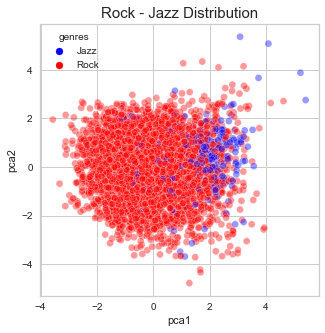

In [63]:
# generating df for plotting PCA
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['pca3'] = pca_proj[:,2] # used for 3D plot
df['genres'] = labels.apply(lambda x: "Rock" if x==1 else "Jazz")

# plot scatter of PCA
plt.figure(figsize=(5,5))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='genres',
    palette={'Jazz':'blue','Rock':'red'},
    data=df,
    legend="full",
    alpha=0.4
)
plt.title("Rock - Jazz Distribution", fontsize= 15)
plt.show()

### 2.3 Plot PCA in 3D

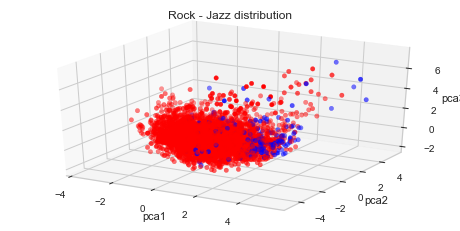

In [64]:
# 3D PCA
#total_var = pca.explained_variance_ratio_.sum() * 100
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection = '3d')

x = df['pca1']
y = df['pca2']
z = df['pca3']
c = df['genres'].apply(lambda x: 1 if x=='Rock' else 0)

ax.set_xlabel("pca1")
ax.set_ylabel("pca2")
ax.set_zlabel("pca3")

scatter = ax.scatter(x, y, z, c=c, cmap='bwr')
ax.set_title('Rock - Jazz distribution')
plt.show()
 


# 3. Split data for classification

In [65]:
# shuffle and split into development set and internal test set:
# (PCA)
X_pca, X_test_pca, y_pca, y_test_pca = train_test_split(
pca_proj, labels, test_size=0.30, random_state=42, stratify=labels)

# (split without PCA)
X_develop, X_test, y_develop, y_test = train_test_split(
dataset, labels, test_size=0.30, random_state=42,stratify= labels)       # not normalized

In [66]:
# check partition
print(f"____Legend____\n1: Rock\n0: Jazz\n\n***PCA***\nDevelopment set:\
\n{y_pca.value_counts()}\n\nInternal Test:\n{y_test_pca.value_counts()}\n\n\
-----------------\n\
***No-PCA***\nDevelopment set:\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

____Legend____
1: Rock
0: Jazz

***PCA***
Development set:
1    2724
0     169
Name: genre_top, dtype: int64

Internal Test:
1    1168
0      72
Name: genre_top, dtype: int64

-----------------
***No-PCA***
Development set:
1    2724
0     169
Name: genre_top, dtype: int64

Internal Test:
1    1168
0      72
Name: genre_top, dtype: int64


# 4. Decision Tree
### a) Full dimensionality

#### - Validation Schema: coarse grid-search with 5 fold CV
We adopt a 5 fold cross validation repeated 10 times and then averaged, in order to reduce the variance of the model.

In [67]:
# search parameters
param_grid = {
               "max_depth": [4,5,6,7,8,9,10],
               "min_samples_leaf": [10,15,25,20,35,45,55],
               "min_samples_split":[10,20,30,40,50],
               "criterion": ["gini", "entropy"]
             }
# instantiate a model
dtc = DecisionTreeClassifier()
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = GridSearchCV(dtc, cv =skfold , param_grid=param_grid, n_jobs=2, verbose=True)
clf.fit(X_develop, y_develop)
# display top 3 models
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

Fitting 5 folds for each of 490 candidates, totalling 2450 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 174 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done 1374 tasks      | elapsed:   27.1s


best parameters:
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 50}
accuracy: 0.9402005605655855


[Parallel(n_jobs=2)]: Done 2450 out of 2450 | elapsed:   45.5s finished


#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc

The roc curve will be saved as:
- roc_auc0

The false and true positive rates will be saved as:
- fpr0
- tpr0

In [67]:
# train and fit
dtc = DecisionTreeClassifier(criterion= 'entropy',max_depth=6, min_samples_leaf= 15, min_samples_split=50)
dtc.fit(X_develop,y_develop)
# predict on internal test set
y_pred_dtc = dtc.predict(X_test)

# display metrics
print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

Accuracy 0.9411290322580645
F1-score [0.3047619  0.96926316]
              precision    recall  f1-score   support

           0       0.48      0.22      0.30        72
           1       0.95      0.99      0.97      1168

    accuracy                           0.94      1240
   macro avg       0.72      0.60      0.64      1240
weighted avg       0.93      0.94      0.93      1240



#### Features importance

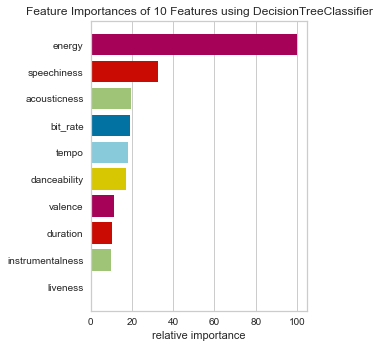

In [31]:
from yellowbrick.model_selection import FeatureImportances

plt.figure(figsize=(5,5))

viz = FeatureImportances(dtc)
viz.fit(X_develop, y_develop)
viz.show()

#### ROC Curve

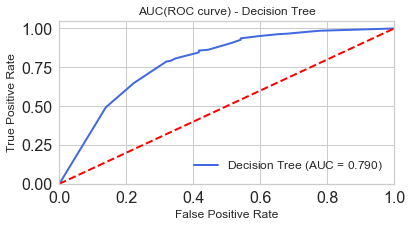

In [32]:
plt.figure(figsize=(6,3))

# y_score0 --> scores of decision tree without PCA
# fpr0, tpr0 ---> false positive and true positive of decision tree without PCA
y_score0 = dtc.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score0[:, 1])

# roc_auc0 --> ROC/AUC of decision tree without PCA
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='royalblue', lw=2, label='Decision Tree$\;$(AUC = %.3f)' % roc_auc0)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('AUC(ROC curve) - Decision Tree', fontsize=12)
plt.legend(loc="lower right", fontsize=12, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion Matrix

Legend:
0: Jazz
1: Rock


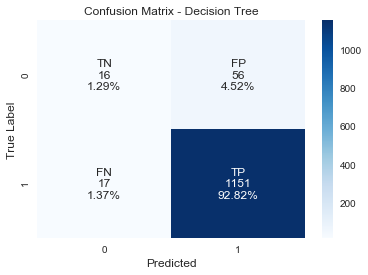

In [38]:
cf_matrix = confusion_matrix(y_test, y_pred_dtc)
print("Legend:\n0: Jazz"
      "\n1: Rock")
plt.figure(figsize=(6,4))
make_confusion_matrix(cf_matrix, 'Confusion Matrix - Decision Tree')

### b) Unbalanced - with PCA ( 8 principal components )
#### Validation schema:  repeated 5 fold cross validation - grid search

In [71]:
# model
dtc_pca = DecisionTreeClassifier()
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = GridSearchCV(dtc, cv =skfold , param_grid=param_grid, n_jobs=2, verbose=True)

clf.fit(X_pca, y_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

Fitting 5 folds for each of 490 candidates, totalling 2450 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 540 tasks      | elapsed:    6.6s


best parameters:
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 25, 'min_samples_split': 20}
accuracy: 0.9408878211449163


[Parallel(n_jobs=2)]: Done 2450 out of 2450 | elapsed:   38.2s finished


#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc_pca

The roc curve will be saved as:
- roc_auc1

The false and true positive rates will be saved as:
- fpr1
- tpr1

In [39]:
dtc_pca = DecisionTreeClassifier(criterion= 'entropy',max_depth=4, min_samples_leaf= 25,min_samples_split=20)
dtc_pca.fit(X_pca,y_pca)

y_pred_dtc_pca = dtc_pca.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test_pca, y_pred_dtc_pca))
print('F1-score %s' % f1_score(y_test_pca, y_pred_dtc_pca, average=None))
print(classification_report(y_test_pca, y_pred_dtc_pca))

Accuracy 0.942741935483871
F1-score [0.18390805 0.97033013]
              precision    recall  f1-score   support

           0       0.53      0.11      0.18        72
           1       0.95      0.99      0.97      1168

    accuracy                           0.94      1240
   macro avg       0.74      0.55      0.58      1240
weighted avg       0.92      0.94      0.92      1240



#### ROC curve

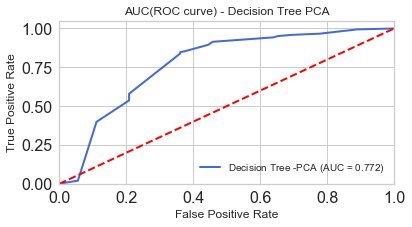

In [41]:
plt.figure(figsize=(6,3))

# y_score1 --> scores of decision tree with PCA
# fpr1, tpr1 ---> false positive and true positive of decision tree with PCA
y_score1 = dtc_pca.predict_proba(X_test_pca)
fpr1, tpr1, _ = roc_curve(y_test_pca, y_score1[:, 1])

# roc_auc1 --> ROC/AUC of decision tree with PCA
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr1, tpr1, color='royalblue', lw=2, label='Decision Tree$\;$-PCA (AUC = %.3f)' % roc_auc1)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('AUC(ROC curve) - Decision Tree PCA', fontsize=12)
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion matrix

Legend:
0: Jazz
1: Rock


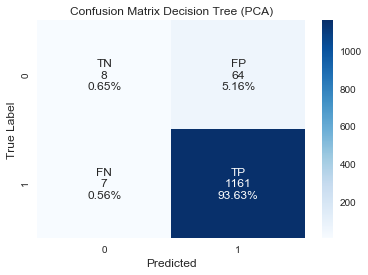

In [43]:
cf_matrix = confusion_matrix(y_test_pca, y_pred_dtc_pca)
print("Legend:\n0: Jazz"
      "\n1: Rock")
plt.figure(figsize=(6,4))
make_confusion_matrix(cf_matrix, 'Confusion Matrix Decision Tree (PCA)')

### c) Comparing Decision tree with and without PCA

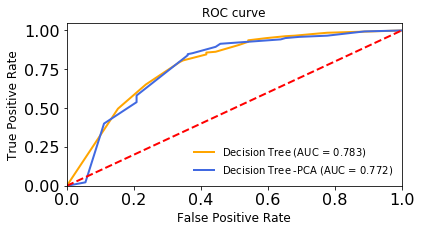

In [72]:
plt.figure(figsize=(6,3))

# ROC of decision tree without PCA
plt.plot(fpr0, tpr0, color='orange', lw=2, label='Decision Tree$\;$(AUC = %.3f)' % roc_auc0)
# ROC of decision tree with PCA
plt.plot(fpr1, tpr1, color='royalblue', lw=2, label='Decision Tree$\;$-PCA (AUC = %.3f)' % roc_auc1)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve', fontsize=12)
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


### Decision tree built with Univariate Feature selection

In [73]:
sel = SelectKBest(k=7)

X_develop_sel = sel.fit_transform(X_develop, y_develop)
X_develop_sel.shape

(2893, 7)

In [77]:
# search parameters
param_grid = {
               "max_depth": [4,5,6,8,10],
               "min_samples_leaf": [5,10,25,20,35,40,45],
            "min_samples_split":[5,10,15,20,25,30],
               "criterion": ["gini", "entropy"]
             }

# instantiate a model
dtc = DecisionTreeClassifier()
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = GridSearchCV(dtc, cv =skfold , param_grid=param_grid, n_jobs=2, verbose=True)
clf.fit(X_develop_sel, y_develop)

#display top 3 models
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")


Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 300 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 1500 tasks      | elapsed:   16.8s


best parameters:
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 35, 'min_samples_split': 5}
accuracy: 0.9401969748582152


[Parallel(n_jobs=2)]: Done 2100 out of 2100 | elapsed:   24.9s finished


In [74]:
X_test_sel = sel.transform(X_test)

dtc_sel = DecisionTreeClassifier(criterion= 'gini',max_depth=4, min_samples_leaf= 35, min_samples_split=5)
dtc_sel.fit(X_develop_sel,y_develop)

y_pred_dtc = dtc_sel.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))


Accuracy 0.9306451612903226
F1-score [0.14       0.96386555]
              precision    recall  f1-score   support

           0       0.25      0.10      0.14        72
           1       0.95      0.98      0.96      1168

    accuracy                           0.93      1240
   macro avg       0.60      0.54      0.55      1240
weighted avg       0.91      0.93      0.92      1240



Legend:
0: Jazz
1: Rock


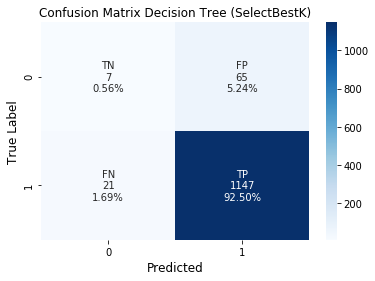

In [76]:
# confusion matrix Decision tree with PCA
cf_matrix = confusion_matrix(y_test, y_pred_dtc)
print("Legend:\n0: Jazz"
      "\n1: Rock")
make_confusion_matrix(cf_matrix, 'Confusion Matrix Decision Tree (SelectBestK)')

# 5. KNN


In [68]:
# normalizing data
scaler.fit(X_develop)
X_develop_norm = scaler.transform(X_develop)
X_test_norm = scaler.transform(X_test)

### a) Unbalanced - without PCA

#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [46]:
# range of k to try - find a good range of k
knn_params = {"n_neighbors":[x for x in range(2, 25)],
           "weights": ["distance","uniform"],
           "metric":["euclidean","manhattan","minkowski"]}

knn = KNeighborsClassifier()
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = GridSearchCV(knn, param_grid= knn_params, cv=skfold)
clf.fit(X_develop_norm, y_develop)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

#report(clf.cv_results_)

KeyboardInterrupt: 

#### Train and predict

In [69]:
knn =  KNeighborsClassifier(n_neighbors = 10, metric= 'manhattan', weights='distance')
# retrain knn on the whole development set
knn.fit(X_develop_norm, y_develop)
# predict target variable
y_pred_knn0 = knn.predict(X_test_norm)

# display classification report
print(classification_report(y_test, y_pred_knn0))
print('legend:\n0: Jazz\n1: Rock')

              precision    recall  f1-score   support

           0       0.48      0.18      0.26        72
           1       0.95      0.99      0.97      1168

    accuracy                           0.94      1240
   macro avg       0.72      0.58      0.62      1240
weighted avg       0.92      0.94      0.93      1240

legend:
0: Jazz
1: Rock


#### ROC curve

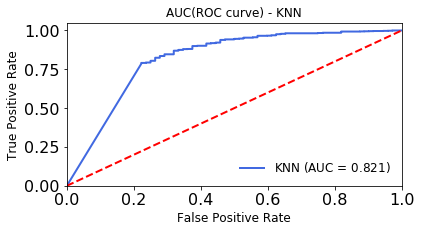

In [87]:
plt.figure(figsize=(6,3))

y_score_knn0 = knn.predict_proba(X_test_norm)
fpr_knn0, tpr_knn0, _ = roc_curve(y_test, y_score_knn0[:, 1])
roc_auc_knn0 = auc(fpr_knn0, tpr_knn0)

plt.plot(fpr_knn0, tpr_knn0, color='royalblue', lw=2, label='KNN$\;$(AUC = %.3f)' % roc_auc_knn0)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('AUC(ROC curve) - KNN', fontsize=12)
plt.legend(loc="lower right", fontsize=12, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion matrix

Legend:
0: Jazz
1: Rock


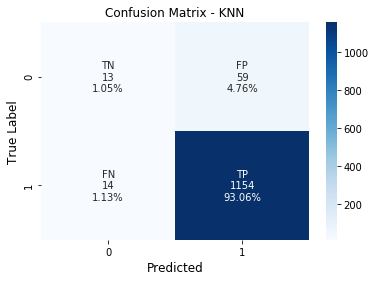

In [88]:
# confusion matrix Decision tree with PCA
cf_matrix = confusion_matrix(y_test, y_pred_knn0)
print("Legend:\n0: Jazz"
      "\n1: Rock")
make_confusion_matrix(cf_matrix, 'Confusion Matrix - KNN')

### b) Unbalanced - with PCA

#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [116]:
# range of k to try - find a good range of k
knn_params = {"n_neighbors":[x for x in range(2, 25)],
           "weights": ["distance","uniform"],
           "metric":["euclidean","manhattan","minkowski"]}

knn = KNeighborsClassifier()
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = GridSearchCV(knn, param_grid= knn_params, cv=skfold )
clf.fit(X_pca, y_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

#report(clf.cv_results_)

best parameters:
{'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}
accuracy: 0.9460763397099164


#### Train and predict

In [89]:
knn_pca =  KNeighborsClassifier(n_neighbors = 8, weights='distance', metric='euclidean')
# retrain knn on the whole development set
knn_pca.fit(X_pca, y_pca)
# predict target variable
y_pred_knn1 = knn_pca.predict(X_test_pca)
# display classification report
print(classification_report(y_test_pca, y_pred_knn1))
print('legend:\n0: Jazz\n1: Rock')

              precision    recall  f1-score   support

           0       0.57      0.18      0.27        72
           1       0.95      0.99      0.97      1168

    accuracy                           0.94      1240
   macro avg       0.76      0.59      0.62      1240
weighted avg       0.93      0.94      0.93      1240

legend:
0: Jazz
1: Rock


####  ROC curve

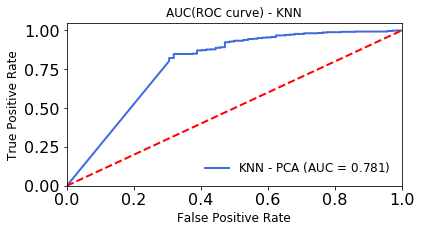

In [92]:
plt.figure(figsize=(6,3))

y_score_knn1 = knn_pca.predict_proba(X_test_pca)
fpr_knn1, tpr_knn1, _ = roc_curve(y_test_pca, y_score_knn1[:, 1])
roc_auc_knn1 = auc(fpr_knn1, tpr_knn1)

plt.plot(fpr_knn1, tpr_knn1, color='royalblue', lw=2, label='KNN$\;$- PCA (AUC = %.3f)' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('AUC(ROC curve) - KNN', fontsize=12)
plt.legend(loc="lower right", fontsize=12, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion matrix

Legend:
0: Jazz
1: Rock


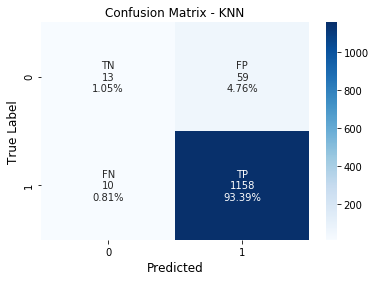

In [93]:
# confusion matrix Decision tree with PCA
cf_matrix = confusion_matrix(y_test_pca, y_pred_knn1)
print("Legend:\n0: Jazz"
      "\n1: Rock")
make_confusion_matrix(cf_matrix, 'Confusion Matrix - KNN')

### c) Comparing KNN with and without PCA

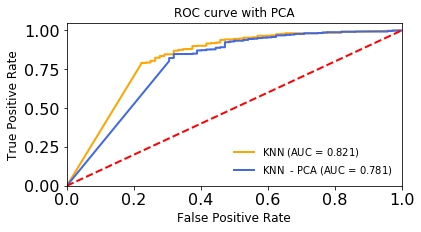

In [94]:
plt.figure(figsize=(6,3))

# ROC KNN without PCA
plt.plot(fpr_knn0, tpr_knn0, color='orange', lw=2, label='KNN$\;$(AUC = %.3f)' % roc_auc_knn0)
# ROC KNN with PCA
plt.plot(fpr_knn1, tpr_knn1, color='royalblue', lw=2, label='KNN$\;$ - PCA (AUC = %.3f)' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve with PCA', fontsize=12)
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### Decision Tree vs KNN (PCA)

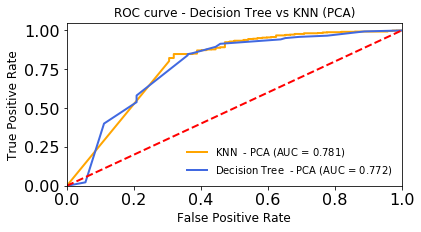

In [97]:
plt.figure(figsize=(6,3))

# KNN with PCA
plt.plot(fpr_knn1, tpr_knn1, color='orange', lw=2, label='KNN$\;$ - PCA (AUC = %.3f)' % roc_auc_knn1)
# DecisionTree with PCA
plt.plot(fpr1, tpr1, color='royalblue', lw=2, label='Decision Tree$\;$ - PCA (AUC = %.3f)' % roc_auc1)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve - Decision Tree vs KNN (PCA)', fontsize=12)
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### Decision Tree vs KNN 

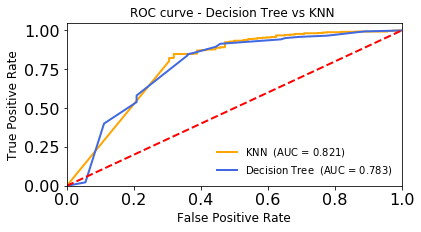

In [98]:
plt.figure(figsize=(6,3))

# KNN with PCA
plt.plot(fpr_knn1, tpr_knn1, color='orange', lw=2, label='KNN$\;$ (AUC = %.3f)' % roc_auc_knn0)
# DecisionTree with PCA
plt.plot(fpr1, tpr1, color='royalblue', lw=2, label='Decision Tree$\;$ (AUC = %.3f)' % roc_auc0)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve - Decision Tree vs KNN ', fontsize=12)
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()